In [ ]:
# Load the data into a data frame.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

data = pd.read_csv('clinicsales.csv')
data.describe()

,clinicnumber,treatment,purchase,numdoctors,avgpanelsize,distance
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,161.500000,1.015528,0.276398,3.934783,2303.751553,35.313665
std,93.097619,0.822053,0.651862,1.170284,141.683691,43.026230
min,1.000000,0.000000,0.000000,1.000000,2050.000000,2.000000
25%,81.250000,0.000000,0.000000,3.000000,2186.000000,9.000000
50%,161.500000,1.000000,0.000000,4.000000,2308.000000,21.000000
75%,241.750000,2.000000,0.750000,5.000000,2419.750000,45.750000
max,322.000000,2.000000,9.000000,7.000000,2546.000000,437.000000


In [ ]:
# Demonstrate balance
# Make a table showing the means of each of the pre-experiment variables ineach treatment arm, and also the number of observations in each treatment arm.

balance_table = data.groupby('treatment')[['numdoctors', 'avgpanelsize', 'distance']].mean()
balance_table[ 'count'] = data.groupby('treatment')['numdoctors'].count()
print(balance_table)

           numdoctors  avgpanelsize   distance  count
treatment                                            
0            3.754717   2291.792453  38.028302    106
1            3.980952   2282.619048  35.161905    105
2            4.063063   2335.162162  32.864865    111


In [ ]:
# Average outcomes
# Calculate the mean of purchase and the 95% confidence interval for the mean,

purchase_mean = data.groupby('treatment')['purchase'].agg(
    mean= ('mean'), std= ('std'), N= ('count')
    )
#print(np_mean)

purchase_mean['se'] = purchase_mean['std'] / np.sqrt(purchase_mean['N'])
purchase_mean['CI_lower'] = purchase_mean['mean'] - 1.96 * purchase_mean['se']
purchase_mean['CI_upper'] = purchase_mean['mean'] + 1.96 * purchase_mean['se']
print(purchase_mean[['mean', 'CI_lower', 'CI_upper']])

               mean  CI_lower  CI_upper
treatment                              
0          0.122642  0.059898  0.185385
1          0.333333  0.242732  0.423934
2          0.369369  0.193904  0.544835


In [ ]:
# Average treatment effects.
# Calculate the ATE on purchase, for each treatment arm.

purchase_ate = purchase_mean['mean'] - purchase_mean['mean'][0]
purchase_ate = purchase_ate.to_frame()
purchase_ate['ate'] = purchase_ate['mean']
purchase_ate.drop(columns=['mean'], inplace=True)
#print(np_ate)

# Calculate and report the 95% CI for the ATE for purchase, for each treatment arm.
# Calcualte the demand multipliers associated with each treatment arm.

purchase_ate['se'] = np.sqrt(purchase_mean['se']**2 + purchase_mean['se'][0]**2)
purchase_ate['lb'] = purchase_ate['ate'] - 1.96*purchase_ate['se']
purchase_ate['ub'] = purchase_ate['ate'] + 1.96*purchase_ate['se']
purchase_ate['multiplier'] = purchase_ate['ate'] / purchase_mean['mean'][0]
print(purchase_ate[["ate", 'lb', 'ub', 'multiplier']][1:])

                ate        lb        ub  multiplier
treatment                                          
1          0.210692  0.100486  0.320898    1.717949
2          0.246728  0.060382  0.433074    2.011781


In [ ]:
# Regression version of ATE.

# Use regression to calculate ATE for purchase, for each treatment arm, and find 95% confidence interval.

formula = 'purchase ~ C(treatment)'
model = smf.ols(formula, data=data).fit()
model = model.get_robustcov_results(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               purchase   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     8.766
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           0.000197
Time:                        21:35:45   Log-Likelihood:                -314.05
No. Observations:                 322   AIC:                             634.1
Df Residuals:                     319   BIC:                             645.4
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1226      0.03

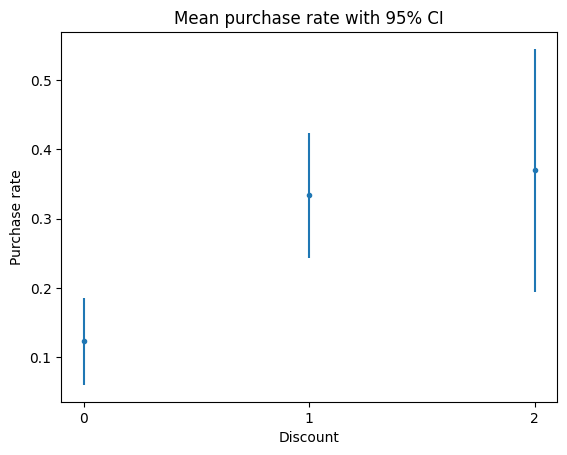

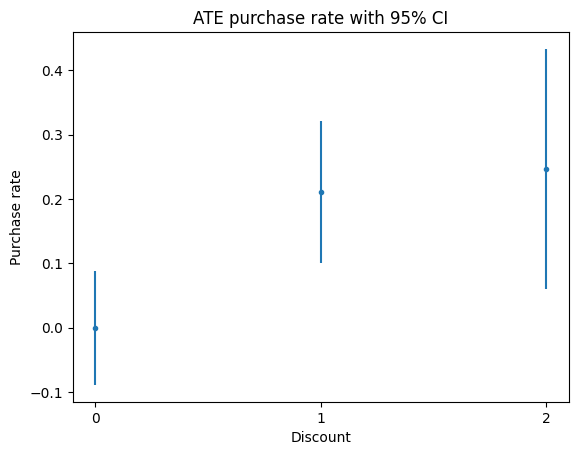

In [ ]:
# Plots

# Make a plot of the means and confidence intervals in each treatment arm,

purchase_mean["error_bar"] = purchase_mean["se"]*1.96
plt.figure()
plt.errorbar(purchase_mean.index, purchase_mean["mean"], fmt = ".", yerr=purchase_mean["error_bar"])
plt.xlabel('Discount')
plt.ylabel('Purchase rate')
plt.title('Mean purchase rate with 95% CI')
plt.xticks([0, 1, 2])
plt.show()


# Repeat for ATE.
purchase_ate["error_bar"] = purchase_ate["se"]*1.96
plt.figure()
plt.errorbar(purchase_ate.index, purchase_ate['ate'], yerr=purchase_ate["error_bar"], fmt='.')

plt.xlabel('Discount')
plt.ylabel('Purchase rate')
plt.title('ATE purchase rate with 95% CI')
plt.xticks([0, 1, 2])
plt.show()
